## Bibliotecas Básicas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def norm(p):
    return np.linalg.norm(p)


def dist(p, q):
    return norm(p - q)

## Enunciado do Problema

Dados $A,B,C,D,E,F \in \mathbb{R}^3$ tais que o triângulo $\Delta ABC$ seja congruente ao triângulo $\Delta DEF$, isto é, 

 - $\operatorname{dist}(A, B) = \operatorname{dist}(D, E);$
 - $\operatorname{dist}(A, C) = \operatorname{dist}(D, F);$
 - $\operatorname{dist}(B, C) = \operatorname{dist}(E, C)$
 
Queremos encontrar uma função $f\colon \mathbb{R}^3\to \mathbb{R}^3$ isométrica que satisfaça:

 - $f(A) = D$;
 - $f(B) = E$;
 - $f(C) = F$.

In [3]:
A = np.array([1, 0, 0])
B = np.array([0, 0, 0])
C = np.array([1, 1, 1])

D = np.array([2, 3, 3])
E = np.array([2, 2, 3])
F = np.array([1, 3, 2])

Geogebra disponível em:
https://www.geogebra.org/3d/jhqzzszy

## Verifica se os pontos dados satisfazem a condição do enunciado 

In [4]:
def is_valid(A, B, C, D, E, F):
    return dist(A, B) == dist(D, E) and dist(A, C) == dist(D, F) and dist(B, C) == dist(E, F)

In [5]:
is_valid(A, B, C, D, E, F)

True

## Mostra os Triângulos

Nosso objetivo é fazer com que o triângulo em azul se torne o vermelho

In [6]:
def triangle(u, v, w):
    px = [u[0], v[0], w[0], u[0]]
    py = [u[1], v[1], w[1], u[1]]
    pz = [u[2], v[2], w[2], u[2]]
    return px, py, pz


def show_triangles(A, B, C, D, E, F):
    print(A, B, C, D, E, F)
    print(is_valid(A, B, C, D, E, F))
    ax = plt.figure().gca(projection="3d")
    px, py, pz = triangle(A, B, C)
    ax.plot(px, py, pz, 'bo-')
    px, py, pz = triangle(D, E, F)
    ax.plot(px, py, pz, 'ro-')
    plt.draw()
    plt.show()

[1 0 0] [0 0 0] [1 1 1] [2 3 3] [2 2 3] [1 3 2]
True


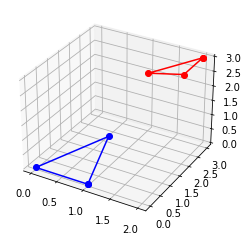

In [7]:
show_triangles(A, B, C, D, E, F)

In [8]:
def angle(u, v):
    u = u / norm(u)
    v = v / norm(v)

    return np.arccos(np.dot(u, v))


def rotation(k, th):
    K = np.array([[0, -k[2], k[1]], [k[2], 0, -k[0]], [-k[1], k[0], 0]])
    #     print(K)
    #     print(np.linalg.det(K))
    #     print(th)

    R = np.identity(3) + np.sin(th) * K + (1 - np.cos(th)) * np.linalg.matrix_power(K, 2)
    #     print(R)
    return R


def colapse_triangles(blue, red, eps=1e-6):
    A0, B0, C0 = np.copy(blue)
    D, E, F = np.copy(red)
    show_triangles(A0, B0, C0, D, E, F)

    ##### translação #####
    A1 = A0 + (D - A0)
    B1 = B0 + (D - A0)
    C1 = C0 + (D - A0)
    show_triangles(A1, B1, C1, D, E, F)

    ### primeira rotação ###

    k = np.cross(B1 - D, E - D)
    if norm(k) < eps:
        if norm(B1 - E) < eps:
            R = np.identity(3)
        else:
            R = -1 * np.identity(3)
    else:
        k = k / norm(k)
        th = angle(B1 - D, E - D)
        R = rotation(k, th)

    A2 = D + R @ (A1 - D)
    B2 = D + R @ (B1 - D)
    C2 = D + R @ (C1 - D)

    show_triangles(A2, B2, C2, D, E, F)

    ### segunda rotação ###

    l = (E - D) / norm(E - D)
    ph = angle(C2 - D, F - D)
    S = rotation(l, ph)

    A3 = D + S @ (A2 - D)
    B3 = D + S @ (B2 - D)
    C3 = D + S @ (C2 - D)

    show_triangles(A3, B3, C3, D, E, F)

    return S @ R

[1 0 0] [0 0 0] [1 1 1] [2 3 3] [2 2 3] [1 3 2]
True


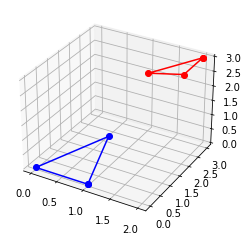

[2 3 3] [1 3 3] [2 4 4] [2 3 3] [2 2 3] [1 3 2]
True


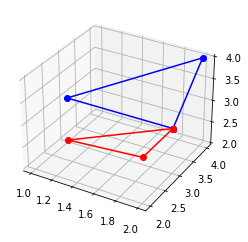

[2. 3. 3.] [2. 2. 3.] [1. 3. 4.] [2 3 3] [2 2 3] [1 3 2]
True


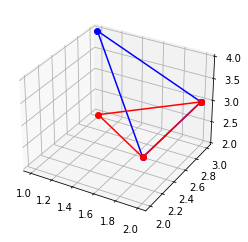

[2. 3. 3.] [2. 2. 3.] [1. 3. 2.] [2 3 3] [2 2 3] [1 3 2]
True


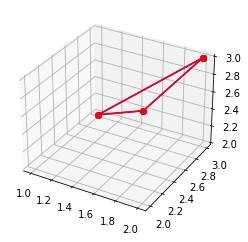

In [9]:
colapse_triangles([A, B, C], [D, E, F]);

## Define f

In [10]:
def angle(u, v):
    u = u / norm(u)
    v = v / norm(v)
    return np.arccos(np.dot(u, v))


def rodrigues(v, th):
    V = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    R = np.identity(3) + np.sin(th) * V + (1 - np.cos(th)) * np.linalg.matrix_power(V, 2)
    return R


def SR_matrix(ABC, DEF, eps=1e-9):
    A, B, C = np.copy(ABC)
    D, E, F = np.copy(DEF)

    if norm((B - A) - (E - D)) < eps:  # if B-A = E-D
        R = np.identity(3)
    elif norm((B - A) + (E - D)) < eps:  # if B-A = -(E-D)
        R = -1 * np.identity(3)
    else:
        k = np.cross(B - A, E - D)
        k = k / norm(k)
        th = angle(B - A, E - D)
        R = rodrigues(k, th)

    l = (E - D) / norm(E - D)
    ph = angle(R @ (C - A), F - D)
    S = rodrigues(l, ph)

    return S @ R


def f(P, ABC, DEF):
    SR = SR_matrix(ABC, DEF)
    A = np.copy(ABC[0])
    D = np.copy(DEF[0])
    return D + SR @ (P - A)

In [11]:
f(C, [A, B, C], [D, E, F]), F

(array([1., 3., 2.]), array([1, 3, 2]))